In [1]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
import csv
from tqdm import tqdm
import random
import seaborn as sns

In [2]:
ROOT = '/data0/lucy/language-map-of-science/'
LOGS = ROOT + 'logs/'
DATA = ROOT + 'data/'

## Metadata abstracts

The results below are for the full metadata dataset for journals that cover medicine. 

Here, "journals" refers to consolidated journal and venue keys. 

We are removing 218,271 small journals and 220 non-english journals (these counts were obtained using `wc -l`). 

In [3]:
with open(LOGS + 'data_counts/journal_counts.json', 'r') as infile: 
    journal_counts = Counter(json.load(infile))
with open(LOGS + 'data_counts/journal_abs_count.json', 'r') as infile: 
    journal_abs_counts = Counter(json.load(infile))
with open(LOGS + 'data_counts/journal_abs_word_count.json', 'r') as infile: 
    journal_abs_word_count = Counter(json.load(infile))

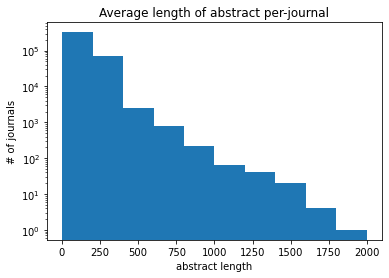

AVERAGE LENGTH: 154.78191048162478

JOURNALS W/ LONGEST ABSTRACTS
multiple choice questions in pain management -#- multiple choice questions in pain management 1997.3333333333333
poisson geometry, deformation quantisation and group representations -#- poisson geometry, deformation quantisation and group representations 1673.0
lc gc north america -#- lc gc north america 1616.0
 -#- in proceedings of the workshop on artificial intelligence for web search 1613.0
 -#- in trecvid workshop 1610.0
transactions of the philological society. philological society -#- transactions of the philological society. philological society 1554.0
practical handbook of environmental site characterization and ground-water monitoring, second edition -#- practical handbook of environmental site characterization and ground-water monitoring, second edition 1525.4
 -#- cs dept., boston university 1522.0
 -#- advances in pervasive computing, ocg press 1520.0
 -#- the structure of ill-structure solutions: boundary o

In [4]:
# how long are abstracts?
avg_abs_len = Counter()
for j in journal_abs_word_count: 
    total_words = journal_abs_word_count[j]
    total_abs = journal_abs_counts[j]
    avg_abs_len[j] = total_words/total_abs
plt.hist(list(avg_abs_len.values()), log=True)
plt.ylabel("# of journals")
plt.xlabel("abstract length")
plt.title("Average length of abstract per-journal")
plt.show()
print("AVERAGE LENGTH:", np.mean(list(avg_abs_len.values())))
print()
print("Journals w/ longest abstracts".upper())
for tup in avg_abs_len.most_common(10): 
    print(tup[0], tup[1])

The cell below examines what proportion of abstracts have journals marked, and which have venues marked, and if both exist, if they agree or disagree. The gist is that rarely both exist AND are inconsistent. 

IN JOURNAL/VENUES w/ ABSTRACTS
electronic colloquium on computational complexity (eccc) -#- electronic colloquium on computational complexity 602
informatica (slovenia) -#- informatica 634
Both missing: 0.0
Only journal missing: 0.411
Only venue missing: 0.113
Both journal and venue exist and are equal: 0.474
Both journal and venue exist and are NOT equal: 0.0008493876709641046
402643 402643

computer science (agh) -#- computer science 246
electronic colloquium on computational complexity (eccc) -#- electronic colloquium on computational complexity 602
informatica (slovenia) -#- informatica 634
electr. notes theor. comput. sci. -#- lsfa 92
arxiv: learning -#- aistats 6
arxiv: optimization and control -#- sdm 1
electr. notes theor. comput. sci. -#- mfps 243
electr. notes theor. comput. sci. -#- cmcs 84
electr. notes theor. comput. sci. -#- lagos 54
arxiv: computation and language -#- naacl 5
arxiv: combinatorics -#- analco 2
electr. notes theor. comput. sci. -#- ctcs 18
arxiv: high ener

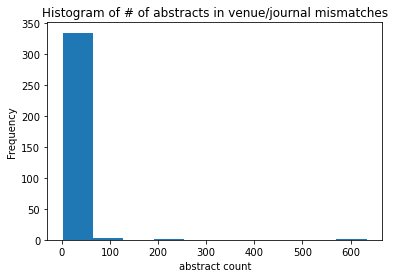

In [6]:
print("IN JOURNAL/VENUES w/ ABSTRACTS")
both_null = 0
journal_null = 0
venue_null = 0
both_exist_nonequal = 0
both_exist_equal = 0
examples = []
number_of_abstracts_in_mismatches = []
for k in journal_abs_counts: 
    no_num_k = ''.join([i for i in k if not i.isdigit()])
    journal_venue = no_num_k.split(' -#- ')
    if journal_venue[0] == '' and journal_venue[1] == '': 
        both_null += 1
    elif journal_venue[0] == '': 
        journal_null += 1
    elif journal_venue[1] == '': 
        venue_null += 1
    elif journal_venue[0] == journal_venue[1]: 
        both_exist_equal += 1
    elif journal_venue[0] != journal_venue[1]: 
        both_exist_nonequal += 1
        examples.append(no_num_k)
        if journal_abs_counts[k] > 500: print(no_num_k, journal_abs_counts[k])
        number_of_abstracts_in_mismatches.append(journal_abs_counts[k])
    else: 
        print(k)
print("Both missing:", both_null / float(len(journal_abs_counts)))
print("Only journal missing:", round(journal_null / float(len(journal_abs_counts)), 3))
print("Only venue missing:", round(venue_null / float(len(journal_abs_counts)), 3))
print("Both journal and venue exist and are equal:", round(both_exist_equal / float(len(journal_abs_counts)), 3))
print("Both journal and venue exist and are NOT equal:", both_exist_nonequal / float(len(journal_abs_counts)))
print(both_null + journal_null + venue_null + both_exist_equal + both_exist_nonequal, len(journal_abs_counts))
print()
for i, e in enumerate(examples[:50]): 
    print(e, number_of_abstracts_in_mismatches[i])
plt.hist(number_of_abstracts_in_mismatches, bins=10)
plt.ylabel("Frequency")
plt.xlabel("abstract count")
plt.title("Histogram of # of abstracts in venue/journal mismatches")
plt.show()

Consolidate journals and venues by doing the following: 
- if only journal exists (~11.4%), use journal
- if only venue exists (~41.1%), use venue
- if both exist and are equal (~47.5%), yay
- if both exist and are not equal (~0.08%), use journal

In [5]:
def consolidate_journal_venues(journal_venue): 
    journal_venue = journal_venue.split(' -#- ')
    journal_venue[0] = journal_venue[0].strip()
    journal_venue[1] = journal_venue[1].strip()
    if journal_venue[0] == '' and journal_venue[1] == '': 
        new_k = ''
    elif journal_venue[0] == '': 
        new_k = journal_venue[1] # use venue
    elif journal_venue[1] == '': 
        new_k = journal_venue[0] # use journal
    elif journal_venue[0] == journal_venue[1]: 
        new_k = journal_venue[0] # both same
    elif journal_venue[0] != journal_venue[1]: 
        new_k = journal_venue[0] # use journal
    return new_k

In [8]:
new_journal_counts = Counter()
new_journal_abs_counts = Counter()
for k in journal_counts: 
    no_num_k = ' '.join([i for i in k.split(' ') if not any(char.isdigit() for char in i)])
    if no_num_k.endswith('-#-'): no_num_k += ' '
    if no_num_k.startswith('-#-'): no_num_k = ' ' + no_num_k
    new_k = consolidate_journal_venues(no_num_k)
    new_journal_counts[new_k] += journal_counts[k]
    
for k in journal_abs_counts: 
    no_num_k = ' '.join([i for i in k.split(' ') if not any(char.isdigit() for char in i)])
    if no_num_k.endswith('-#-'): no_num_k += ' '
    if no_num_k.startswith('-#-'): no_num_k = ' ' + no_num_k
    new_k = consolidate_journal_venues(no_num_k)
    new_journal_abs_counts[new_k] += journal_abs_counts[k]
journal_counts = new_journal_counts
journal_abs_counts = new_journal_abs_counts

In [9]:
print("TOTAL # OF \"journal/venue\":", len(journal_counts))
print("TOTAL # OF \"journal/venue\" with abstracts:", len(journal_abs_counts))
print("TOTAL # OF ENTRIES:", sum(journal_counts.values()))

TOTAL # OF "journal/venue": 546286
TOTAL # OF "journal/venue" with abstracts: 374869
TOTAL # OF ENTRIES: 88949931


TOTAL # of JOURNAL/VENUE WITH ABSTRACT: 220985
PERCENT of JOURNAL/VENUE WITH ABSTRACT: 40.45

If a journal has abstracts, it has 209.231 abstracts on average.



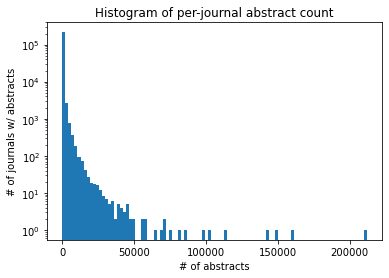

MEDIAN: 12.0 

90th percentile: 354.0
JOURNAL/VENUE IN 90th PERCENTILE: 22098.5
95th percentile: 846.0
JOURNAL/VENUE IN 95th PERCENTILE: 11049.25
99.9th percentile: 13897.144000000291
JOURNAL/VENUE IN 99.9th PERCENTILE: 220.985

MOST COMMON JOURNAL/VENUE W/ ABSTRACTS
plos one - 211727 - 0.46
ssrn electronic journal - 160578 - 0.35
arxiv - 149113 - 0.32
advanced materials research - 143550 - 0.31
applied mechanics and materials - 112921 - 0.24
scientific reports - 101824 - 0.22
blood - 98374 - 0.21
cancer research - 86246 - 0.19
the journal of biological chemistry - 80631 - 0.17
applied physics letters - 76115 - 0.16

MOST COMMON JOURNAL/VENUE W/O ABSTRACTS
 - 26026200
experientia - 15396
uk tree care mailing list - 7929
chemical shifts and coupling constants for - 7680
zeitschrift für kristallographie - new crystal structures - 6645
clinical psychiatry news - 4473
journal of the history of philosophy - 4186
pediatric news - 3447
krankenpflege. soins infirmiers - 3430
the thomist: a spe

In [10]:
has_abstract = 0
total_abstracts = [] # for journals that have them
for j in journal_abs_counts: 
    if journal_abs_counts[j] > 1: 
        if j != 'null': 
            total_abstracts.append(journal_abs_counts[j])
        has_abstract += 1
print("TOTAL # of JOURNAL/VENUE WITH ABSTRACT:", has_abstract)
print("PERCENT of JOURNAL/VENUE WITH ABSTRACT:", round(has_abstract/len(journal_counts)*100, 2))
print()
avg = round(np.mean(total_abstracts), 3)
print("If a journal has abstracts, it has", avg, "abstracts on average.")
print()

plt.hist(list(total_abstracts), log=True, bins=100)
plt.ylabel("# of journals w/ abstracts")
plt.xlabel("# of abstracts")
plt.yscale('log')
plt.title("Histogram of per-journal abstract count")
plt.show()

print('MEDIAN:', np.median(total_abstracts), '\n')
print('90th percentile:', np.percentile(total_abstracts, 90))
print("JOURNAL/VENUE IN 90th PERCENTILE:", 0.1*has_abstract)
print('95th percentile:', np.percentile(total_abstracts, 95))
print("JOURNAL/VENUE IN 95th PERCENTILE:", 0.05*has_abstract)
print('99.9th percentile:', np.percentile(total_abstracts, 99.9))
print("JOURNAL/VENUE IN 99.9th PERCENTILE:", 0.001*has_abstract)
print()

print("MOST COMMON JOURNAL/VENUE W/ ABSTRACTS")
total_num_abstracts = sum(journal_abs_counts.values())
for tup in journal_abs_counts.most_common(10): 
    print(tup[0], '-', tup[1], '-', round(tup[1]*100/total_num_abstracts, 2))
print()

no_abstract = Counter()
for j in journal_counts: 
    if journal_abs_counts[j] == 0: 
        no_abstract[j] = journal_counts[j]
print("MOST COMMON JOURNAL/VENUE W/O ABSTRACTS")
for tup in no_abstract.most_common(10): 
    print(tup[0], '-', tup[1])

Is the coverage of abstracts **all-or-nothing** on a per-journal basis? Kinda.

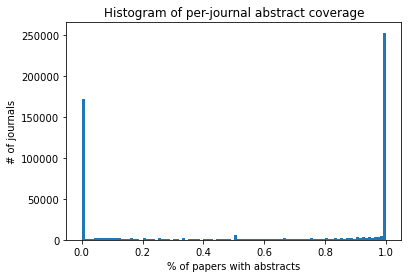

In [11]:
journal_abs_frac = Counter()
for j in journal_counts: 
    total_this_journal = journal_counts[j]
    abs_this_journal = journal_abs_counts[j]
    journal_abs_frac[j] = abs_this_journal / float(total_this_journal)
    assert journal_abs_frac[j] <= 1.0
plt.hist(list(journal_abs_frac.values()), bins=100)
plt.title("Histogram of per-journal abstract coverage")
plt.ylabel("# of journals")
plt.xlabel("% of papers with abstracts")
plt.show()

In [12]:
print("# of white-spaced tokens in abstracts:", "{:,}".format(sum(journal_abs_word_count.values())))

# of white-spaced tokens in abstracts: 7,999,919,363


In [13]:
with open(LOGS + 'data_counts/year_count.json', 'r') as infile: 
    year_counts = Counter(json.load(infile))
with open(LOGS + 'data_counts/contempt_count.json', 'r') as infile: 
    contempt_count = Counter(json.load(infile))

In [14]:
print("Total over all years:", sum(year_counts.values()))
print("Total over contemporary only:", sum(contempt_count.values()))

Total over all years: 136595995
Total over contemporary only: 46390812


In [15]:
year_x = []
count_y = []
null_count = 0
future_count = 0
old_count = 0
for year in sorted(year_counts):
    if year == 'null': 
        null_count += 1
        continue
    if int(year) >= 2023: 
        future_count += 1
        continue
    if int(year) < 1900: 
        old_count += 1
        continue
    y = datetime.strptime(year, '%Y')
    year_x.append(y)
    count_y.append(year_counts[year])
print("Number of unknown years:", null_count)
print("Number of future years:", future_count)
print("Number of old years:", old_count)

Number of unknown years: 1
Number of future years: 20
Number of old years: 823


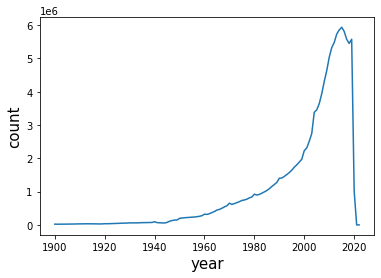

In [16]:
plt.plot(year_x, count_y)
plt.xlabel("year", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.show()

## Dataset balanced via FOS

We ended up using only this dataset, not the one balanced by journals, because we are more interested in language specialized to different fields (some journals might be in the same field or cross fields). 

In [3]:
all_papers_df = pd.read_parquet(LOGS + 'metadata_counts/result_parquets/')

In [ ]:
clean_all_papers_df = all_papers_df[all_papers_df['valid'] == True]
clean_all_papers_df.loc[:, 'clean journal/venue'] = clean_all_papers_df.loc[:, 'journal/venue'].apply(consolidate_journal_venues)
clean_all_papers_df.loc[:, 'fos list'] = clean_all_papers_df.loc[:, 'fos'].apply(lambda x: x.split(','))
clean_all_papers_df = clean_all_papers_df.drop(columns=['valid', 'journal/venue', 'fos'])
clean_all_papers_df

<ipython-input-6-e4cd352d9fcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_all_papers_df.loc[:, 'clean journal/venue'] = clean_all_papers_df.loc[:, 'journal/venue'].apply(consolidate_journal_venues)


In [ ]:
df_by_field = clean_all_papers_df.explode('fos list')

In [ ]:
level_to_topics = defaultdict(set)
with open(DATA + 'fos_level.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        level_to_topics[row['level']].add(row['displayname'].lower())

In [92]:
clean_all_papers_df['level 1 fos list'] = clean_all_papers_df['fos list'].apply(lambda x: [i for i in x if i not in level_to_topics['0']])
clean_all_papers_df['num level 1'] = clean_all_papers_df['level 1 fos list'].apply(len)
num_level1 = Counter(clean_all_papers_df['num level 1'].to_list())
total = sum(num_level1.values())
for num in num_level1: 
    print(num, num_level1[num], round(num_level1[num] / total, 3))
clean_all_papers_df

1 28031139 0.604
2 18176588 0.392
3 135902 0.003
0 45655 0.001
4 1508 0.0
5 20 0.0


,paper id,clean journal/venue,fos list,level 1 fos list,num level 1
1,77491955,archivos españoles de urología,"[surgery, medicine]",[surgery],1
18,77497951,blood,"[gastroenterology, surgery, medicine]","[gastroenterology, surgery]",2
25,94550757,materials chemistry and physics,"[materials science, mineralogy, chemical engin...","[mineralogy, chemical engineering]",2
27,94551239,current applied physics,"[nanotechnology, optoelectronics, computer sci...","[nanotechnology, optoelectronics]",2
28,94551428,particuology,"[inorganic chemistry, chemistry]",[inorganic chemistry],1
...,...,...,...,...,...
88949909,111506286,water and energy international,"[water resource management, archaeology, engin...","[water resource management, archaeology]",2
88949910,111506487,guangzhou chemical industry,"[engineering, petroleum engineering]",[petroleum engineering],1
88949911,111506675,fire technology,[simulation],[simulation],1
88949922,111508991,journal of mechanical science and technology,"[speech recognition, algorithm]","[speech recognition, algorithm]",2


In [93]:
level_to_children = defaultdict(set)
with open(DATA + 'mag_parent_child.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        if row['parent_display_name'].lower() in level_to_topics['0']: 
            if row['child_display_name'].lower() in level_to_topics['1']: 
                level_to_children[row['parent_display_name'].lower()].add(row['child_display_name'].lower())

In [94]:
top_level_papers = defaultdict(list)
second_level_papers = defaultdict(list)
no_level_papers = defaultdict(list)
for field, y in tqdm(df_by_field.groupby('fos list')): 
    if field in level_to_topics['0']: 
        top_level_papers[field] = y['paper id'].to_list()
    elif field in level_to_topics['1']:
        second_level_papers[field] = y['paper id'].to_list()
    else: 
        top_level_papers[field] = y['paper id'].to_list()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:31<00:00, 10.02it/s]


In [95]:
print("Overlap w/ Medicine")
print("Biology", len(set(top_level_papers['biology']) & set(top_level_papers['medicine'])))
print("Chemistry", len(set(top_level_papers['chemistry']) & set(top_level_papers['medicine'])))

Overlap w/ Medicine
Biology 115
Chemistry 0


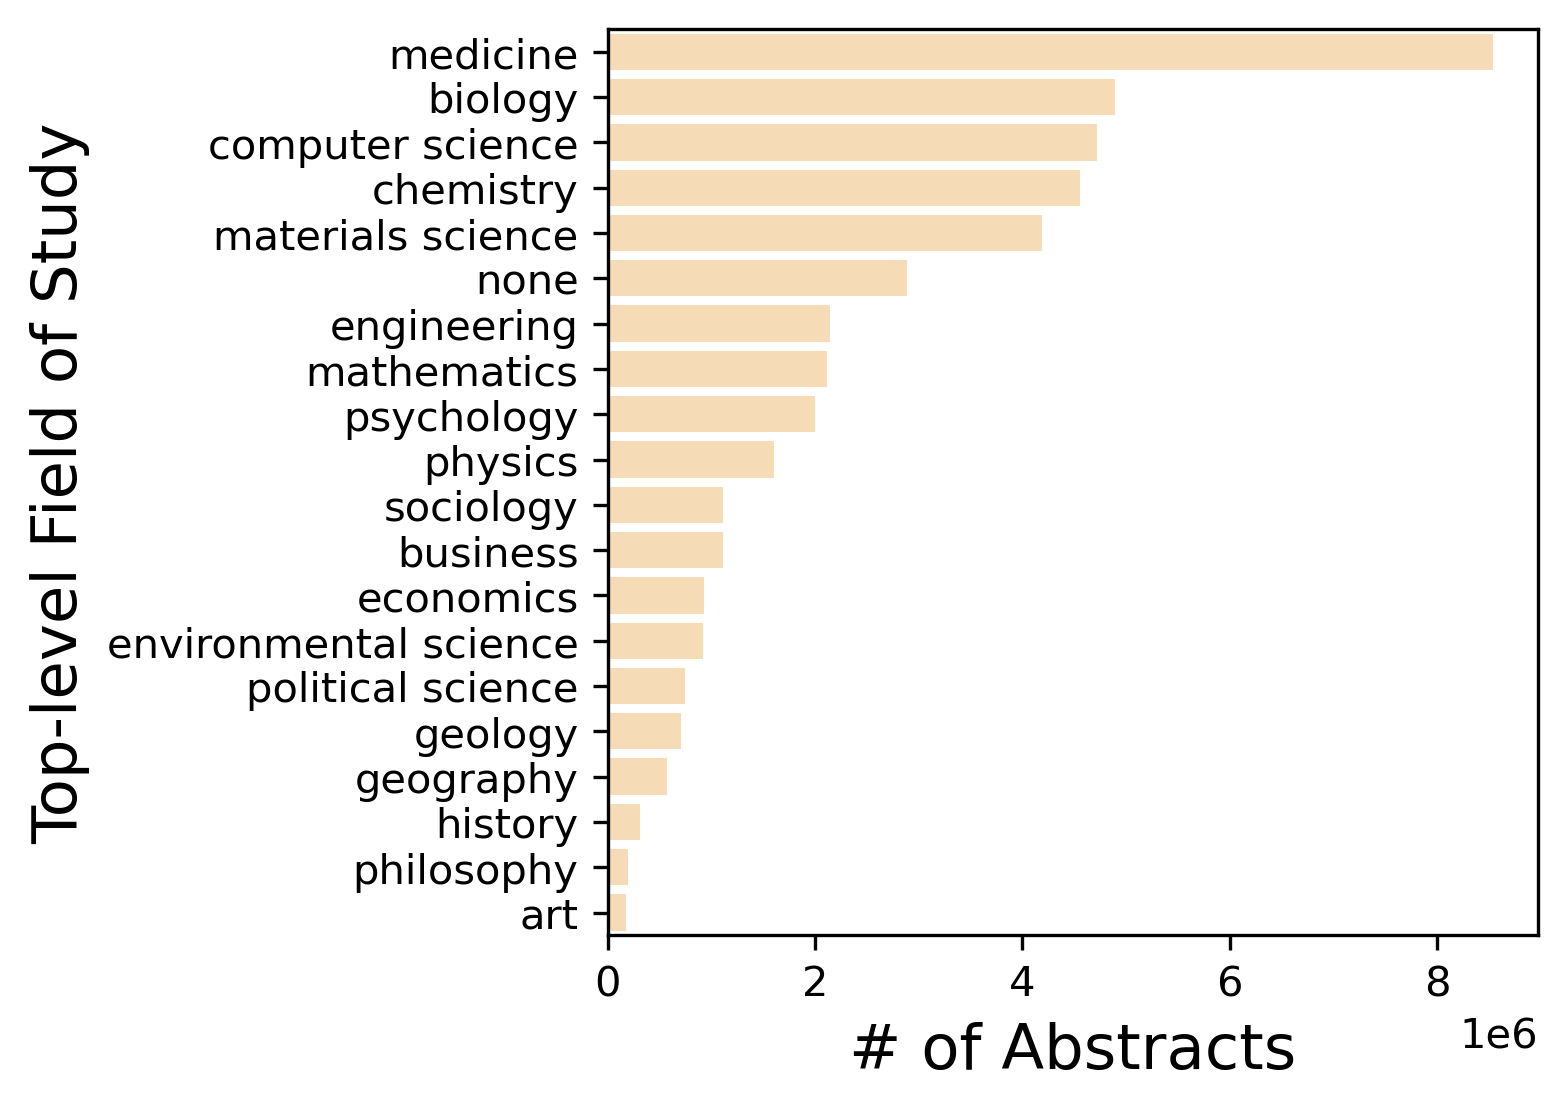

In [97]:
d_level_0 = {
    'fos': [], 
    'count': [],
}

for fos in top_level_papers: 
    d_level_0['fos'].append(fos)
    d_level_0['count'].append(len(top_level_papers[fos]))
    
d_level_0 = pd.DataFrame.from_dict(d_level_0)
    
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(ax=ax, data=d_level_0, x="count", y="fos", 
            color="navajowhite", order=d_level_0.sort_values('count').fos[::-1])
plt.yticks(fontsize=10)
plt.xlabel("# of Abstracts", fontsize=15)
plt.ylabel("Top-level Field of Study", fontsize=15)
plt.show()

In [98]:
for field in top_level_papers: 
    print(field, len(top_level_papers[field]))
    if field not in level_to_children: continue
    print("\tCHILDREN:", len(level_to_children[field]))
    children_counts = Counter()
    second_level_set = set()
    for child in level_to_children[field]: 
        children_counts[child] = len(second_level_papers[child])
        second_level_set.update(second_level_papers[child])
    other_top_level_papers = set(top_level_papers[field]) - second_level_set
    children_counts['OTHER ' + field] = len(other_top_level_papers)
    for child_tup in children_counts.most_common(): 
        print('\t', child_tup)

art 180009
	CHILDREN: 6
	 ('literature', 235947)
	 ('aesthetics', 154206)
	 ('art history', 98940)
	 ('visual arts', 75195)
	 ('classics', 64812)
	 ('humanities', 53088)
	 ('OTHER art', 28075)
biology 4893705
	CHILDREN: 32
	 ('endocrinology', 1200096)
	 ('immunology', 943774)
	 ('biochemistry', 909644)
	 ('cell biology', 812726)
	 ('molecular biology', 687280)
	 ('ecology', 674746)
	 ('genetics', 642342)
	 ('botany', 616670)
	 ('cancer research', 517347)
	 ('pharmacology', 498394)
	 ('microbiology', 438488)
	 ('neuroscience', 373838)
	 ('food science', 373440)
	 ('agronomy', 369672)
	 ('virology', 361611)
	 ('anatomy', 358505)
	 ('OTHER biology', 260123)
	 ('horticulture', 252654)
	 ('biophysics', 241827)
	 ('animal science', 206541)
	 ('zoology', 206207)
	 ('bioinformatics', 192772)
	 ('computational biology', 179468)
	 ('biotechnology', 111051)
	 ('fishery', 104076)
	 ('paleontology', 99793)
	 ('physiology', 92839)
	 ('evolutionary biology', 92280)
	 ('toxicology', 85130)
	 ('agrofor

	 ('control theory', 682947)
	 ('algorithm', 677932)
	 ('mathematical optimization', 449108)
	 ('OTHER mathematics', 444934)
	 ('mathematical analysis', 444204)
	 ('mathematics education', 354158)
	 ('discrete mathematics', 261810)
	 ('statistics', 257684)
	 ('combinatorics', 246884)
	 ('applied mathematics', 209051)
	 ('pure mathematics', 189577)
	 ('econometrics', 188531)
	 ('operations research', 180720)
	 ('topology', 114907)
	 ('geometry', 108821)
	 ('algebra', 86233)
	 ('mathematical physics', 73443)
	 ('mathematical economics', 49921)
	 ('calculus', 46395)
	 ('arithmetic', 26534)
	 ('computational science', 25477)
medicine 8543941
	CHILDREN: 45
	 ('surgery', 1845450)
	 ('endocrinology', 1200096)
	 ('immunology', 943774)
	 ('pathology', 855087)
	 ('cardiology', 563888)
	 ('anesthesia', 544943)
	 ('gastroenterology', 517498)
	 ('cancer research', 517347)
	 ('internal medicine', 507846)
	 ('radiology', 500899)
	 ('pharmacology', 498394)
	 ('pediatrics', 461351)
	 ('physical therapy

### FOS analysis sample

50k papers per level 1 FOS 

Including “other” categories for small / no level 1 FOS papers in each level 0 FOS, and papers with no FOS as “none”

In [100]:
random.seed(0)
fos_paper_sample = defaultdict(list)
sample_size = 50000

for field in tqdm(top_level_papers): 
    if field not in level_to_children: 
        # none category
        continue
    second_level_set = set()
    current_other_bucket = set()
    # level 1 FOS 
    for child in level_to_children[field]: 
        if len(second_level_papers[child]) >= sample_size: 
            fos_paper_sample[child] = random.sample(second_level_papers[child], sample_size)
        else: 
            # too small, put in other
            current_other_bucket.update(second_level_papers[child])
        second_level_set.update(second_level_papers[child])
    # other 
    other_top_level_papers = set(top_level_papers[field]) - second_level_set
    all_other_bucket = other_top_level_papers | current_other_bucket
    if len(all_other_bucket) < sample_size: continue
    fos_paper_sample['OTHER ' + field] = random.sample(list(all_other_bucket), sample_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.19s/it]


In [101]:
for field in fos_paper_sample: 
    print(field, len(fos_paper_sample[field]))

art history 50000
classics 50000
humanities 50000
visual arts 50000
literature 50000
aesthetics 50000
computational biology 50000
biochemistry 50000
bioinformatics 50000
cancer research 50000
evolutionary biology 50000
anatomy 50000
molecular biology 50000
pharmacology 50000
immunology 50000
virology 50000
ecology 50000
agronomy 50000
botany 50000
toxicology 50000
food science 50000
microbiology 50000
biological system 50000
agroforestry 50000
biophysics 50000
animal science 50000
paleontology 50000
cell biology 50000
physiology 50000
endocrinology 50000
horticulture 50000
genetics 50000
biotechnology 50000
neuroscience 50000
fishery 50000
zoology 50000
OTHER biology 50000
international trade 50000
accounting 50000
risk analysis (engineering) 50000
process management 50000
actuarial science 50000
marketing 50000
industrial organization 50000
finance 50000
advertising 50000
OTHER business 50000
polymer chemistry 50000
molecular physics 50000
organic chemistry 50000
physical chemistry 50

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83802.28it/s]


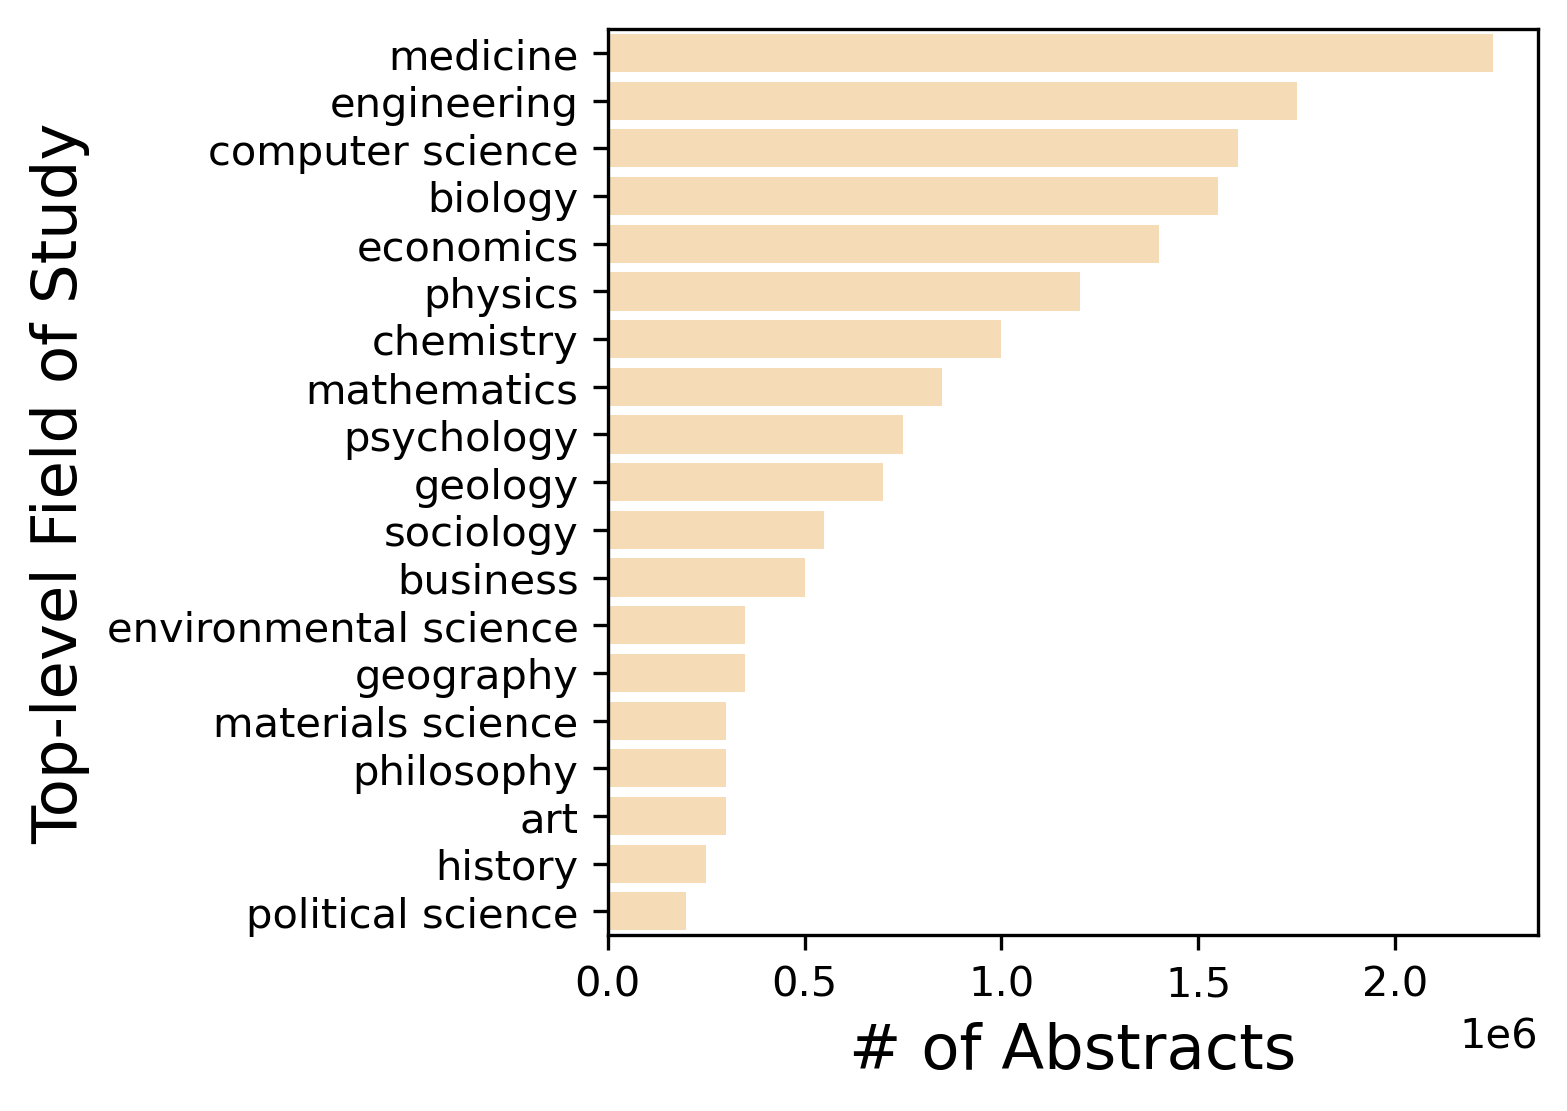

In [102]:
d_level_0 = {
    'fos': [], 
    'count': [],
}

for field in tqdm(top_level_papers): 
    if field not in level_to_children or not level_to_children[field]: # none
        continue
    total = 0
    for child in level_to_children[field]:
        if child not in fos_paper_sample: continue
        total += len(fos_paper_sample[child])
    if 'OTHER ' + field in fos_paper_sample: 
        total += len(fos_paper_sample['OTHER ' + field])
    d_level_0['fos'].append(field)
    d_level_0['count'].append(total)

d_level_0 = pd.DataFrame.from_dict(d_level_0)
    
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(ax=ax, data=d_level_0, x="count", y="fos", 
            color="navajowhite", order=d_level_0.sort_values('count').fos[::-1])
plt.yticks(fontsize=10)
plt.xlabel("# of Abstracts", fontsize=15)
plt.ylabel("Top-level Field of Study", fontsize=15)
plt.show()

In [115]:
## Output appendix text here 
for field in top_level_papers: 
    if field not in level_to_children: continue
    all_children = []
    for child in level_to_children[field]: 
        if child in fos_paper_sample: 
            all_children.append(child)
    if ('OTHER ' + field) in fos_paper_sample: 
        all_children.append(field + ' (other)')
    print(field.title() +  ' (' + str(len(all_children)) + ' children):', ', '.join(all_children) + '.')

Art (6 children): art history, classics, humanities, visual arts, literature, aesthetics.
Biology (31 children): computational biology, biochemistry, bioinformatics, cancer research, evolutionary biology, anatomy, molecular biology, pharmacology, immunology, virology, ecology, agronomy, botany, toxicology, food science, microbiology, biological system, agroforestry, biophysics, animal science, paleontology, cell biology, physiology, endocrinology, horticulture, genetics, biotechnology, neuroscience, fishery, zoology, biology (other).
Business (10 children): international trade, accounting, risk analysis (engineering), process management, actuarial science, marketing, industrial organization, finance, advertising, business (other).
Chemistry (20 children): polymer chemistry, molecular physics, biochemistry, organic chemistry, physical chemistry, chemical physics, nuclear chemistry, medicinal chemistry, photochemistry, combinatorial chemistry, computational chemistry, analytical chemistr

In [84]:
print("Number of fields of study:", len(fos_paper_sample))

Number of fields of study: 263


The below was run to write out the sample (we avoid rerunning this in case there are changes in sampling, though we do set a random seed). 

```
papers_to_keep = set()
for field in fos_paper_sample: 
    papers_to_keep.update(fos_paper_sample[field])
with open(DATA + 'input_paper_ids/fos_analysis.txt', 'w') as outfile: 
    for paper_id in papers_to_keep: 
        outfile.write(str(paper_id) + '\n')
        
s2orc_fos = defaultdict(list)
for field in fos_paper_sample: 
    for paper_id in fos_paper_sample[field]: 
        s2orc_fos[paper_id].append(field)
os.makedirs(LOGS + 'wiktionary/', exist_ok=True)
with open(LOGS + 'wiktionary/s2orc_fos.json', 'w') as outfile:
    json.dump(s2orc_fos, outfile)
```

### Journal analysis sample

800 papers per journal in top 95th percentile

We didn't end up using this journal sample in our pipeline (there are some components built for it, but some are deprecated).  

In [52]:
journal_abs_counts = Counter(clean_all_papers_df['clean journal/venue'].to_list())

In [62]:
journal_abs_ids = defaultdict(list)
cutoff = np.percentile(total_abstracts, 95)
for journal, y in tqdm(clean_all_papers_df.groupby('clean journal/venue')):
    if journal_abs_counts[journal] > cutoff: 
        journal_abs_ids[journal] = y['paper id'].to_list()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 374869/374869 [00:32<00:00, 11454.11it/s]


In [71]:
random.seed(0)
journal_paper_sample = defaultdict(list)
sample_size = 800
for journal in journal_abs_ids: 
    journal_paper_sample[journal] = random.sample(journal_abs_ids[journal], sample_size)

In [73]:
papers_to_keep = set()
for journal in journal_paper_sample: 
    papers_to_keep.update(journal_paper_sample[journal])
with open(DATA + 'input_paper_ids/journal_analysis.txt', 'w') as outfile: 
    for paper_id in papers_to_keep: 
        outfile.write(str(paper_id) + '\n')

In [91]:
with open(DATA + 'input_paper_ids/s2orc_journal.json', 'w') as outfile: 
    json.dump(journal_paper_sample, outfile)

In [77]:
journal_df = clean_all_papers_df[clean_all_papers_df['paper id'].isin(papers_to_keep)]
journal_df = journal_df.explode('fos list')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:11<00:00, 28.26it/s]


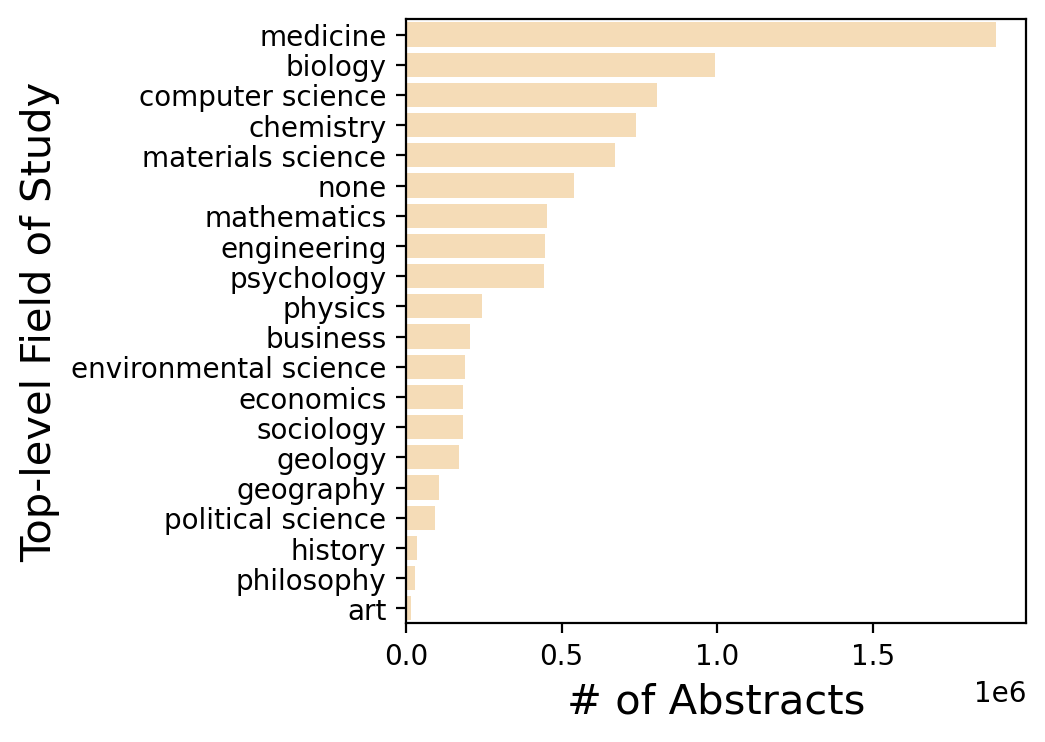

In [78]:
d_level_0 = {
    'fos': [], 
    'count': [],
}

for field, y in tqdm(journal_df.groupby('fos list')): 
    if field in level_to_topics['0'] or field == 'none': 
        d_level_0['fos'].append(field)
        d_level_0['count'].append(y.shape[0])

d_level_0 = pd.DataFrame.from_dict(d_level_0)
    
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
sns.barplot(ax=ax, data=d_level_0, x="count", y="fos", 
            color="navajowhite", order=d_level_0.sort_values('count').fos[::-1])
plt.yticks(fontsize=10)
plt.xlabel("# of Abstracts", fontsize=15)
plt.ylabel("Top-level Field of Study", fontsize=15)
plt.show()

In [85]:
print("Number of journal/venues:", len(journal_paper_sample))

Number of journal/venues: 11047


In [102]:
journal_df.to_csv(DATA + 'input_paper_ids/journal_df.csv')

## Scientific success regression dataset 

In [39]:
with open(LOGS + 'wiktionary/s2orc_fos.json', 'r') as infile:
    s2orc_fos = json.load(infile)

In [52]:
journals_to_keep = set(journal_df['clean journal/venue'].unique())
# filter to only journals found in journal_df
top_journal_df = clean_all_papers_df[clean_all_papers_df['clean journal/venue'].isin(journals_to_keep)] 
all_papers_in_top_journals = set(top_journal_df['paper id'].unique())

In [57]:
# load parquets that contain time and place 
time_fos_df = pd.read_parquet(LOGS + 'citing_papers/')

In [59]:
time_fos_df

,paper_id,fos,year
0,77490837,"medical emergency,family medicine,business",2001
1,77491955,"surgery,medicine",2000
2,77492438,"engineering ethics,medicine",2008
3,77493177,"endocrinology,medicine",2015
4,77493227,"library science,medicine",2011
...,...,...,...
88949926,111508739,none,2010
88949927,111508791,"control theory,control engineering,engineering",2000
88949928,111509354,"horticulture,agronomy",2007
88949929,111509659,"automotive engineering,manufacturing engineeri...",2008


In [71]:
paper_year = dict(zip(time_fos_df.paper_id, time_fos_df.year))

In [60]:
early_papers = set(time_fos_df[time_fos_df['year'].isin(range(2000, 2015))]['paper_id'].unique())

In [65]:
child_to_parents = defaultdict(set)
for parent in level_to_children: 
    for child in level_to_children[parent]: 
        child_to_parents[child].add(parent)

In [68]:
papers_left = defaultdict(list) # { level 0 fos : [papers to regress]}
for paper_id in tqdm(s2orc_fos): 
    # paper journal needs to be in top 95th percentile
    if paper_id not in all_papers_in_top_journals: continue
    # published between 2000-2014
    if paper_id not in early_papers: continue

    fos_list = s2orc_fos[paper_id]
    this_parent_child = defaultdict(list) # {parent : [children]}
    keep = True
    for fos in fos_list: 
        if fos.startswith("OTHER "): 
            keep = False
        if fos in level_to_topics['1']: 
            parents = child_to_parents[fos]
            for parent in parents: 
                this_parent_child[parent].append(fos)
    if not keep: continue
    for fos in this_parent_child: 
        children_fos_list = this_parent_child[fos]
        if len(children_fos_list) > 2 or len(children_fos_list) < 1: 
            continue
        papers_left[fos].append({'paper_id': paper_id, 'level 1 fos': children_fos_list})

100%|█████████████████████████████████████████████████████████████| 11990654/11990654 [01:00<00:00, 199575.69it/s]


In [79]:
paper_journal = dict(zip(top_journal_df['paper id'], top_journal_df['clean journal/venue']))
paper_journal_small = {}
for paper_id in tqdm(paper_journal): 
    if paper_id not in s2orc_fos and paper_id not in early_papers: 
        continue
    paper_journal_small[paper_id] = paper_journal[paper_id]
with open(LOGS + 'regression/papers_to_journals.json', 'w') as outfile: 
    json.dump(paper_journal_small, outfile)

100%|█████████████████████████████████████████████████████████████| 33079134/33079134 [00:51<00:00, 644866.67it/s]


In [73]:
with open(LOGS + 'regression/papers_to_regress.json', 'w') as outfile:
    json.dump(papers_left, outfile)

In [72]:
for fos in papers_left: 
    years = [paper_year[d['paper_id']] for d in papers_left[fos]]
    year_buckets = Counter()
    for y in years: 
        if y < 2005: 
            year_buckets[2000] += 1
        elif y < 2010: 
            year_buckets[2005] += 1
        else: 
            year_buckets[2010] += 1
    print(fos, len(papers_left[fos]))
    print(year_buckets)
    print()

art 68230
Counter({2005: 27518, 2010: 25376, 2000: 15336})

philosophy 68517
Counter({2005: 28113, 2010: 25553, 2000: 14851})

economics 454441
Counter({2010: 211596, 2005: 161698, 2000: 81147})

psychology 261105
Counter({2010: 117124, 2005: 89139, 2000: 54842})

engineering 786828
Counter({2010: 369506, 2005: 283945, 2000: 133377})

sociology 149495
Counter({2010: 65434, 2005: 53722, 2000: 30339})

business 160711
Counter({2010: 75263, 2005: 58269, 2000: 27179})

computer science 556414
Counter({2010: 257203, 2005: 210217, 2000: 88994})

history 47919
Counter({2010: 18613, 2005: 17824, 2000: 11482})

geography 127570
Counter({2010: 58739, 2005: 43507, 2000: 25324})

biology 824785
Counter({2010: 350093, 2005: 276437, 2000: 198255})

political science 45020
Counter({2010: 19240, 2005: 16983, 2000: 8797})

medicine 1137940
Counter({2010: 520093, 2005: 375230, 2000: 242617})

mathematics 363394
Counter({2010: 156887, 2005: 130131, 2000: 76376})

environmental science 137867
Counter({201